In [1]:
import numpy as np
from cosmoTransitions import generic_potential as gp
from cosmoTransitions.finiteT import Jb_spline as Jb
from cosmoTransitions.finiteT import Jf_spline as Jf

v2=15000.**2
g=0.65
gX=np.sqrt(0.36**2 * g**2 / (g**2 - 0.36**2))
yt=0.7
yN=0.65

In [32]:
class parity_model(gp.generic_potential):
    def init(self, lR):
        self.Ndim = 1
        self.x_eps = 1e-1
        self.T_eps = 1e-3
        self.lR = lR
        self.gX = gX
        self.yt = yt
        self.yN = yN
        self.g = g
        self.renormScaleSq = v2
        self.Tmax = 6000
    def forbidPhaseCrit(self, X):
        """
        forbidPhaseCrit is useful to set if there is, for example, a Z2 symmetry
        in the theory and you don't want to double-count all of the phases. In
        this case, we're throwing away all phases whose zeroth (since python
        starts arrays at 0) field component of the vev goes below -5. Note that
        we don't want to set this to just going below zero, since we are
        interested in phases with vevs exactly at 0, and floating point numbers
        will never be accurate enough to ensure that these aren't slightly
        negative.
        """
        return (np.array([X])[..., 0] < -5.0).any()

    def V0(self, X):
        X = np.asanyarray(X)
        phi = X[..., 0]
        r = -0.5*self.lR*v2*phi**2 + 0.25*self.lR*phi**4
        return r

    def boson_massSq(self,X,T):
        X = np.array(X)
        phi = X[..., 0]
        phi2 = phi**2

        mW = 0.25 * self.g**2 * phi2
        mB = 0.25 * self.gX**2 * phi2
        mZ = mW + mB
        mH = 3*self.lR*phi2 - self.lR * v2
        mX = self.lR*phi2 - self.lR * v2

        M = np.array([mW, mZ, mH,mX])
        M = np.rollaxis(M, 0, len(M.shape))

        dof = np.array([6, 3, 1, 3])

        return M, dof
    
    
    def thermal_boson_massSq(self, X,T):
        X = np.array(X)
        phi = X[..., 0]
        T = np.array(T)
        T2 = T*T
        

        phi2=phi**2

        mW = 0.25 * self.g**2 * phi2
        mB = 0.25 * self.gX**2 * phi2
        mZ = mW + mB

        thermal_W = 11.*self.g**2 * T2/6.
        thermal_X = 29.*self.gX**2 * T2/18.

        square=np.sqrt(mW**2 + 2*mW*(mB + thermal_W + thermal_W) + (mB - thermal_W + thermal_X)**2)
        mBL = 0.5*(mZ + thermal_W + thermal_X - square)
        mZL = 0.5*(mZ + thermal_W + thermal_X + square)
        mWL = mW + thermal_W

        mH = 3*self.lR*phi2 - self.lR * v2 + 0.5* self.lR *T2 + 0.25 * self.yt**2 * T2 + 0.125 * self.g**2 * T2 + (self.g**2 + self.gX**2)*T2/16.
        mX = self.lR*phi2 - self.lR * v2 + 0.5* self.lR *T2 + 0.25 * self.yt**2 * T2 + 0.125 * self.g**2 * T2 + (self.g**2 + self.gX**2)*T2/16.
        M = np.array([mWL, mZL, mBL,mH, mX])
        M = np.rollaxis(M, 0, len(M.shape))

        dof = np.array([2, 1, 1, 1, 3])

        return M, dof 

    def fermion_massSq(self, X):
        X = np.array(X)
        phi=X[...,0]
        phi2 = phi**2
        mt = 0.5 * self.yt**2 * phi2
        mN = 0.5*self.yN**2 * phi2
        Mf = np.array([mt,mN])
        Mf = np.rollaxis(Mf, 0, len(Mf.shape))
        doff = np.array([12,8])
        return Mf, doff

    def VB(self, X):
        X = np.asanyarray(X)
        phi = X[..., 0]
        mW0T = (self.g**2)*v2*0.25
        mH0T = 2*self.lR*v2
        mZ0T = (self.g**2 + self.gX**2)*v2*0.25
        mt0T = 0.5 * self.yt**2 * v2
        mN0T = 0.5 * self.yN**2 * v2
        B = 6*mW0T**2 + 3*mZ0T**2 + mH0T**2 - 12*mt0T**2 - 8*mN0T**2
        y = 2*B*v2*phi**2 - 1.5*B*phi**4 + B*np.log(phi**2/v2+1e-100) * phi**4
        return y/(64*np.pi**2 * v2**2)
        
    def V1T(self, bosons, fermions, T,include_radiation=True):
        T2 = (T*T)[...,np.newaxis]+1e-100
        T4 = T*T*T*T
        m2,nb = bosons

        y=np.sum(nb*Jb(np.abs(m2)/T2), axis = -1)
        m2, nf = fermions
        y += np.sum(nf*Jf(m2/T2),axis = -1)

        return y*T4/(2*np.pi*np.pi)


    def Vtot(self, X, T,include_radiation=True):
        T = np.asanyarray(T, dtype=float)
        X = np.asanyarray(X, dtype=float)

        bosons = self.boson_massSq(X,T)
        fermions = self.fermion_massSq(X)
        Vtot = self.V0(X)
        Vtot += self.VB(X)
        Vtot += self.V1T(bosons, fermions,T,include_radiation)

        return Vtot

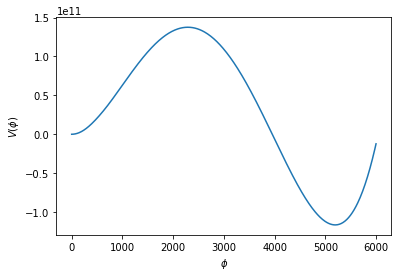

In [33]:
m=parity_model(0.015)
m.plot1d(0,6000,T=4200)

In [34]:
m.findAllTransitions()

Tracing phase starting at x = [14999.99990587] ; t = 0.0
Tracing minimum up
traceMinimum t0 = 0
.............................................................................................................................................................................
Tracing phase starting at x = [2.77555756e-17] ; t = 4222.045727050732
Tracing minimum down
traceMinimum t0 = 4222.05
.....................................................
Tracing minimum up
traceMinimum t0 = 4222.05
...
Tunneling from phase 1 to phase 0 at T=4118.412
high_vev = [-0.6670115]
low_vev = [7217.54360502]
Path deformation converged. 1 steps. fRatio = 1.26012e-13


/Users/isaac/envs/py386/lib/python3.8/site-packages/cosmoTransitions/tunneling1D.py:331: RuntimeWarning: overflow encountered in double_scalars
  beta_r = beta*r
/Users/isaac/envs/py386/lib/python3.8/site-packages/cosmoTransitions/tunneling1D.py:331: RuntimeWarning: overflow encountered in double_scalars
  beta_r = beta*r
/Users/isaac/envs/py386/lib/python3.8/site-packages/cosmoTransitions/tunneling1D.py:331: RuntimeWarning: overflow encountered in double_scalars
  beta_r = beta*r
/Users/isaac/envs/py386/lib/python3.8/site-packages/cosmoTransitions/tunneling1D.py:415: RuntimeWarning: overflow encountered in double_scalars
  r *= 10
/Users/isaac/envs/py386/lib/python3.8/site-packages/cosmoTransitions/tunneling1D.py:331: RuntimeWarning: overflow encountered in double_scalars
  beta_r = beta*r


[]